IASD Data science Project: Attack of networks

# Import modules and data

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torchattacks

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4


train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Network to attack

In [ ]:
class Attackme(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(32, 64, 5)
    #self.conv3 = nn.Conv2d(64, 128, 5)
    self.fc1 = nn.Linear(64 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)    

  def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      #x = self.pool(F.relu(self.conv3(x)))
      x = torch.flatten(x, 1) # flatten all dimensions except batch
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return x

def training(model,epochs,device):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  for ep in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):

        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{ep + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0


## Atack mechanisms

FGSM

In [ ]:
from torch.autograd import Variable

class FGSM(object):
  def __init__(self, model, criterion,adv_training=False,plot_ex=False):
      self.model = model
      self.criterion = criterion
      self.adv_training = adv_training
      self.plot_ex = plot_ex

  def attack(self, x, y, eps, x_min=-1, x_max=1):

    x2 = Variable(x,requires_grad = True)

    output = self.model(x2)

    pred = output.max(1, keepdim=True)[1]
    
    cost = self.criterion(output,y)

    self.model.zero_grad()

    cost.backward()

    x_grad = x2.grad.data
  
    x_attacked = x + eps*(x_grad.sign())
    x_attacked = torch.clamp(x_attacked,x_min,x_max)

    if self.adv_training:
      return x_attacked
    elif self.plot_ex:
      y_attacked = self.model(x_attacked)
      return x_attacked,y_attacked
    else:
      y_attacked = self.model(x_attacked)
      return y_attacked


In [ ]:
fgsm = FGSM(model, nn.CrossEntropyLoss())
eps = 0.15


tot = 0
ok = 0

for images, labels in test_loader:
  images, labels = images.to(device), labels.to(device)
  y_attacked = fgsm.attack(images,labels,eps)
  predicted = y_attacked.max(1, keepdim=True)[1]
  tot += len(labels)
  ok += (predicted.T[0] == labels).sum().item()


print(f'Accu: {100 * ok / tot} %')

PGD Attack

In [ ]:
class PGD(object):
  def __init__(self, model, criterion,adv_training=False,plot_ex=False):
      self.model = model
      self.criterion = criterion
      self.adv_training = adv_training
      self.plot_ex = plot_ex

  def attack(self, x, y, eps, r=1/255, x_min=-1, x_max=1,iters=10):

    x0 = x
    
    for i in range(iters):
      x = Variable(x,requires_grad = True)
      output = self.model(x)
      pred = output.max(1, keepdim=True)[1]
      cost = self.criterion(output,y)
      self.model.zero_grad()
      cost.backward()
      x_grad = x.grad.data
      x = x + r*(x_grad.sign())
      eta = torch.clamp(x-x0,min=-eps,max=eps)
      x = torch.clamp(x0+eta,x_min,x_max)

    if self.adv_training:
      return x
    elif self.plot_ex:
      y_attacked = self.model(x)
      return x,y_attacked
    else:
      y_attacked = self.model(x)
      return y_attacked

In [ ]:
pgd = PGD(model, nn.CrossEntropyLoss())
eps = 0.15

tot = 0
ok = 0
i=0
for images, labels in tqdm(test_loader):
  images, labels = images.to(device), labels.to(device)
  y_attacked = pgd.attack(images,labels,eps)

  predicted = y_attacked.max(1, keepdim=True)[1]
  tot += len(labels)
  ok += (predicted.T[0] == labels).sum().item()
  i += 1

print(f'Accu: {100 * ok / tot} %')

100%|██████████| 2500/2500 [00:54<00:00, 46.21it/s]

Accu: 6.11 %


In [ ]:
class PGDL2(object):

  def __init__(self, model, criterion,adv_training=False):
      self.model = model
      self.criterion = criterion
      self.adv_training = adv_training



  def project(self, x, eps, p=2):
    if p=="inf":
        x = torch.clamp(x,-eps,eps)
    else:
        norms =  torch.norm(x.view(x.size(0),-1),dim=1,p=p) + 1e-6
        #norms[norms==0] = 1                          # To avoid division by zero
        #mask  = (norms > eps)                        # We select only inputs of the batch with a norm > eps
        factor = eps / norms
        factor = torch.min(factor, torch.ones_like(norms))
        x = x*factor.view(-1,1,1,1)       # Project onto p-norm ball of radius 1
        
                                      # Multiply by eps
 
    return x

  def attack_PGD(self, model, x, y, eps, stepsize, iterations=30, p=2, targeted=False):
    #modele.eval()  # We put the model in eval mode to avoid any stochasticity

    # Start with a random point inside norm-ball
    if p=="inf":
        delta = (torch.rand(x.size()) * 2 - 1) * eps    # Each values ~ uniform(-eps,eps)
    else:
        
        delta = torch.randn_like(x)                                             # Generate random direction
        norms = torch.norm(delta.view(delta.size(0),-1), dim=1, p=p)
        #norms[norms==0] = 1  
        
                                                       # To avoid division by zero
        delta /= norms.view(-1,1,1,1)                                           # Project onto p-norm ball of radius 1
        delta *= torch.rand((delta.size(0),1,1,1)).to(device) * eps                       # Multiply each value by f ~ uniform(0,eps)
        
        
    delta = delta.to(device)
    # Iterately take a step of fixed norm, the project on p-norm ball if necessary
    for i in range(iterations):
        x_adv = x + delta
        x_adv.requires_grad_(True)
        logits = model(torch.clamp(x_adv,0,1))
        loss   = F.cross_entropy(logits,y)
        #loss.backward()

        if targeted: 
          loss = -loss

        # Update image with a fixed stepsize
        if p=="inf":
            gradient = torch.sign(x_adv.grad) * stepsize
        else:
          
            gradient  = torch.autograd.grad(loss, x_adv,
                                       retain_graph=False, create_graph=False)[0]                                               # Take the gradient direction
            norms     = torch.norm(gradient.view(gradient.size(0),-1),dim=1,p=p) + 1e-6
            #norms[norms==0] = 1                                                   # To avoid division by zero
            gradient /= norms.view(-1,1,1,1)                                      # Project onto p-norm ball of radius 1
            gradient *= stepsize                                                  # Multipy by stepsize

        #if not targeted :   x_adv = x_adv.detach() + gradient 
        #else:               x_adv = x_adv.detach() - gradient

        x_adv = x_adv.detach() + gradient 

        # Project delta onto p-norm ball of radius eps if necessary
        delta = (x_adv - x).detach()
        delta = self.project(delta, eps, p)


    x = x.detach()
    model.zero_grad()
    x_attacked = torch.clamp(x + delta,0,1)

    if self.adv_training:
      return x_attacked
    else:
      y_attacked = self.model(x_attacked)
      return y_attacked

In [ ]:
pgd2 = PGDL2(model, nn.CrossEntropyLoss())
eps = 0.1
stepsize = 0.2
iterations = 30


tot = 0
ok = 0
i=0
for images, labels in tqdm(test_loader):
  images, labels = images.to(device), labels.to(device)
  y_attacked = pgd2.attack_PGD(model,images,labels,eps,stepsize, iterations)

  predicted = y_attacked.max(1, keepdim=True)[1]
  tot += len(labels)
  ok += (predicted.T[0] == labels).sum().item()
  i += 1

print(f'Accu: {100 * ok / tot} %')

100%|██████████| 15/15 [42:52<00:00, 171.50s/it]


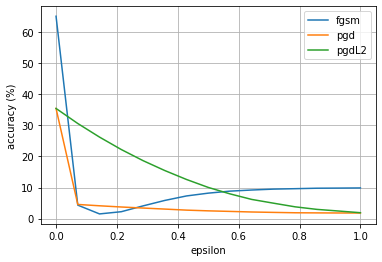

In [ ]:
fgsm = FGSM(model, nn.CrossEntropyLoss())
pgd = PGD(model, nn.CrossEntropyLoss())
pgd2 = PGDL2(model, nn.CrossEntropyLoss())
Eps = np.linspace(0,1,15)

l_eps,l_acc_fgsm,l_acc_pgd, l_acc_pgdl2 = [],[],[], []

for eps in tqdm(Eps):
  tot = 0
  ok = 0
  ok2 = 0
  okl2 = 0

  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    y_attacked = pgd2.attack_PGD(model, images,labels,eps, 0.2,30)
    predicted = y_attacked.max(1, keepdim=True)[1]
    okl2 += (predicted.T[0] == labels).sum().item()

    y_attacked = fgsm.attack(images,labels,eps)
    predicted = y_attacked.max(1, keepdim=True)[1]
    tot += len(labels)
    ok += (predicted.T[0] == labels).sum().item()

    y_attacked = pgd.attack(images,labels,eps)
    predicted = y_attacked.max(1, keepdim=True)[1]
    ok2 += (predicted.T[0] == labels).sum().item()


  l_eps.append(eps)
  l_acc_fgsm.append(100 * ok / tot)
  l_acc_pgd.append(100 * ok2 / tot)
  l_acc_pgdl2.append(100 * okl2 / tot)


plt.figure(1)
plt.plot(l_eps,l_acc_fgsm,label='fgsm')
plt.plot(l_eps,l_acc_pgd,label='pgd')
plt.plot(l_eps,l_acc_pgdl2,label='pgdL2')
plt.grid()
plt.legend()
plt.xlabel('epsilon')
plt.ylabel('accuracy (%)')
plt.show()


plot examples

In [ ]:
def plot_ex(attack,n_ex=4,l_eps=[0,0.005,0.5]):

  if attack == 'fgsm':
    att = FGSM(model, nn.CrossEntropyLoss(),plot_ex=True)
  else: 
    att = PGD(model, nn.CrossEntropyLoss(),plot_ex=True)

  plt.figure(figsize=(8,6))
 
  c=0
  
  
  for eps in l_eps:
    ite =0

    for images, labels in test_loader:
      ite+=1


      if ite ==4:
        images, labels = images.to(device), labels.to(device)
        x_attacked,y_attacked = att.attack(images,labels,eps)
        #x_attacked,y_attacked = images, model(images)
        x_attacked,y_attacked = x_attacked.squeeze().detach().cpu().numpy(),y_attacked.squeeze().detach().cpu()
        conf = F.softmax(y_attacked, dim=1)
        conf = torch.max(conf.data, 1)[0][0]
        predicted = y_attacked.max(1, keepdim=True)[1]
        for i in range(len(x_attacked.data)):
          c+=1
          x_att = x_attacked[i]
          plt.subplot(len(l_eps),n_ex,c)
          plt.xticks([], [])
          plt.yticks([], [])  
          #if eps == l_eps[0]:
          plt.ylabel("Eps: {}".format(eps), fontsize=14)
          plt.title("{} conf:{}%".format(classes[predicted[i]],round(float(conf)*100,2)))
          plt.imshow(x_att[0,:,:])

        break

  plt.tight_layout()
  plt.show()
  


In [ ]:
plot_ex('fgsm')

NameError: ignored

## Adversarial Training

naive defense

In [ ]:
def adv_training(model,epochs, device, alpha = 0.5,eps=0.15,train_fgsm=False, train_pgd=False,train_clean=True, train_pgdL2 = False):
  fgsm = FGSM(model, nn.CrossEntropyLoss(),adv_training=True)
  pgd = PGD(model, nn.CrossEntropyLoss(), adv_training=True)
  pgd2 = PGDL2(model, nn.CrossEntropyLoss(), adv_training=True)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  for ep in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):  

        images, labels = data[0].to(device), data[1].to(device)

        # FGSM Attack
        if train_fgsm:
          optimizer.zero_grad()
          x_attacked = fgsm.attack(images,labels,eps)
          outputs = model(x_attacked)
          loss = alpha*criterion(outputs, labels)+(1-alpha)*criterion(outputs,labels)
          loss.backward()
          optimizer.step()

        # PGD Attack
        if train_pgd:
          optimizer.zero_grad()
          x_attacked = pgd.attack(images,labels,eps)
          outputs = model(x_attacked)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

        #PGD L2
        if train_pgdL2:
          optimizer.zero_grad()
          x_attacked = pgd2.attack_PGD(model,images,labels,eps, 0.2, epochs)
          outputs = model(x_attacked)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

        if train_clean:        
          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{ep + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

# Train

In [ ]:
model=Attackme()
model.to(device)

epochs = 5
adv_training(model,epochs,device,train_clean=True,train_pgd=True  ,train_pgdL2 = True, eps = 0.40)



[1,  2000] loss: 2.020
[1,  4000] loss: 1.795
[1,  6000] loss: 1.735
[1,  8000] loss: 1.688
[1, 10000] loss: 1.639
[1, 12000] loss: 1.618
[2,  2000] loss: 1.582
[2,  4000] loss: 1.571
[2,  6000] loss: 1.560
[2,  8000] loss: 1.515
[2, 10000] loss: 1.522
[2, 12000] loss: 1.506
[3,  2000] loss: 1.483
[3,  4000] loss: 1.493
[3,  6000] loss: 1.468
[3,  8000] loss: 1.460
[3, 10000] loss: 1.475
[3, 12000] loss: 1.461
[4,  2000] loss: 1.428
[4,  4000] loss: 1.453
[4,  6000] loss: 1.407
[4,  8000] loss: 1.449
[4, 10000] loss: 1.413
[4, 12000] loss: 1.438
[5,  2000] loss: 1.398
[5,  4000] loss: 1.405
[5,  6000] loss: 1.390
[5,  8000] loss: 1.413
[5, 10000] loss: 1.397
[5, 12000] loss: 1.388


In [ ]:
torch.save(model.state_dict(),'model_A3.pth' )

In [ ]:
tot = 0
ok = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        tot += labels.size(0)
        ok += (predicted == labels).sum().item()

print(f'Accuracy without attack: {100 * ok // tot} %')

Accuracy without attack: 48 %


In [ ]:
fgsm = FGSM(model, nn.CrossEntropyLoss())
pgd = PGD(model, nn.CrossEntropyLoss())
pgdL2 = PGDL2(model, nn.CrossEntropyLoss())

eps = 0.4
tot = 0
ok = 0
ok2, ok3 = 0, 0

for images, labels in tqdm(test_loader):
  images, labels = images.to(device), labels.to(device)
  tot += len(labels)

  y_attacked = fgsm.attack(images,labels,eps)
  predicted = y_attacked.max(1, keepdim=True)[1]
  ok += (predicted.T[0] == labels).sum().item()

  y_attacked = pgd.attack(images,labels,eps)
  predicted = y_attacked.max(1, keepdim=True)[1]
  ok2 += (predicted.T[0] == labels).sum().item()

  y_attacked = pgdL2.attack_PGD(model,images,labels,eps, 0.2, epochs)
  predicted = y_attacked.max(1, keepdim=True)[1]
  ok3 += (predicted.T[0] == labels).sum().item()


print(f'Accuracy under FGSM attack: {100 * ok // tot} %')
print(f'Accuracy under PGD attack: {100 * ok2 // tot} %')

print(f'Accuracy under PGDL2 attack: {100 * ok3 // tot} %')


